# Three-arm Antenna Position Calibration

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on three arms which are placed approximately 120 degrees apart.  This notebook will use measurements to infer the actual layout of the antennas.

Arm 1 will point geographically north (NOT magnetic). This arm forms the y-axis and will be used as a reference. We will assume that the x positions along this arm are approximately zero.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
x0 = [0,0]

In [3]:
# pip install pandas
# pip install odfpy

import pandas as pd

#pd.read_excel('three_arm_measurements.ods', engine='odf')
cols = [f"A {i}" for i in range(24)]
data = pd.read_excel('three_arm_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

A 0      210.0
A 1      410.0
A 2      384.0
A 3      638.0
A 4      212.0
A 5      753.0
A 6     1261.0
A 7     1436.0
A 8     1707.0
A 9     1864.0
A 10    2199.0
A 11    2386.0
A 12     937.0
A 13    1084.0
A 14    1621.0
A 15    1924.0
A 16    2091.0
A 17    2408.0
A 18     914.0
A 19    1254.0
A 20    1575.0
A 21    1696.0
A 22    1856.0
A 23    2076.0
Name: 0, dtype: float64

## Finding the antennas

This is done by measuring the distance from each antenna to x0 as well as each other antenna. The distance $m_0$ are the measurements to $x_0$. The array m_ij are the distances between antennas.

In [4]:
n_ant = 24
m_0 = np.zeros(24)
m_ij = np.zeros((24,24))

radius = data.loc[0]

for i in range(24):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [5]:
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            m_ij[j,i] = m_ij[i,j]

m_ij


array([[   0.,  198.,  509.,  756.,  365.,  872., 1054., 1225., 1489.,
        1656., 1984., 2183., 1046., 1189., 1713., 2023., 2187., 2506.,
        1027., 1372., 1691., 1814., 1969., 2192.],
       [ 198.,    0.,  673.,  894.,  545., 1021.,  855., 1027., 1293.,
        1459., 1790., 1981., 1169., 1313., 1823., 2127., 2293., 2613.,
        1173., 1506., 1823., 1945., 2098., 2316.],
       [ 509.,  673.,    0.,  258.,  524., 1001., 1467., 1634., 1893.,
        2056., 2384., 2575.,  557.,  701., 1229., 1538., 1705., 2026.,
        1152., 1488., 1807., 1928., 2082., 2305.],
       [ 756.,  894.,  258.,    0.,  772., 1214., 1639., 1802., 2054.,
        2213., 2534., 2721.,  299.,  444.,  973., 1284., 1447., 1768.,
        1357., 1682., 1992., 2113., 2261., 2479.],
       [ 365.,  545.,  524.,  772.,    0.,  535., 1385., 1558., 1819.,
        1984., 2312., 2507., 1066., 1209., 1735., 2037., 2205., 2525.,
         697., 1042., 1366., 1490., 1644., 1867.],
       [ 872., 1021., 1001., 1214.,

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [6]:
import requests
import json

def get_data(path):
    server = "https://tart.elec.ac.nz/rhodes"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

if False:
    with open('original_rhodes_positions.json', "r") as f:
        data = f.read()
    cal_json = json.loads(data)
    current_pos = cal_json['antenna_positions'] # get_pos()
    current_pos = np.array(current_pos)

if False:
    current_pos = get_pos()
    json_result = {}
    json_result["antenna_positions"] = current_pos.tolist()
    print(json.dumps(json_result, indent=4, separators=(',', ': ')))

current_pos = np.array([[ 0.        ,  0.21036822,  0.        ],
       [ 0.        ,  0.40894464,  0.        ],
       [ 0.33652171, -0.1942909 ,  0.        ],
       [ 0.55195215, -0.31866972,  0.        ],
       [-0.18186395, -0.1049992 ,  0.        ],
       [-0.65058666, -0.37561638,  0.        ],
       [ 0.        ,  1.26747133,  0.        ],
       [ 0.        ,  1.44403899,  0.        ],
       [ 0.        ,  1.71019648,  0.        ],
       [ 0.        ,  1.86051529,  0.        ],
       [ 0.        ,  2.20143587,  0.        ],
       [ 0.        ,  2.38582938,  0.        ],
       [ 0.81594596, -0.47108662,  0.        ],
       [ 0.94307482, -0.5444845 ,  0.        ],
       [ 1.40247705, -0.8097205 ,  0.        ],
       [ 1.66872406, -0.96343829,  0.        ],
       [ 1.80943056, -1.04467522,  0.        ],
       [ 2.08400692, -1.20320196,  0.        ],
       [-0.78741312, -0.45461318,  0.        ],
       [-1.08399029, -0.62584208,  0.        ],
       [-1.36391741, -0.78745808,  0.        ],
       [-1.46598234, -0.8463853 ,  0.        ],
       [-1.60875644, -0.92881597,  0.        ],
       [-1.80004538, -1.03925669,  0.        ]])

0.0 210.36822
0.0 408.94464000000005
336.52171 -194.2909
551.95215 -318.66972
-181.86395 -104.9992
-650.5866599999999 -375.61638000000005
0.0 1267.47133
0.0 1444.03899
0.0 1710.19648
0.0 1860.5152899999998
0.0 2201.4358700000003
0.0 2385.82938
815.94596 -471.08662000000004
943.0748199999999 -544.4845
1402.47705 -809.7204999999999
1668.72406 -963.43829
1809.43056 -1044.67522
2084.0069200000003 -1203.2019599999999
-787.4131199999999 -454.61318
-1083.99029 -625.84208
-1363.91741 -787.45808
-1465.98234 -846.3853
-1608.75644 -928.81597
-1800.04538 -1039.25669


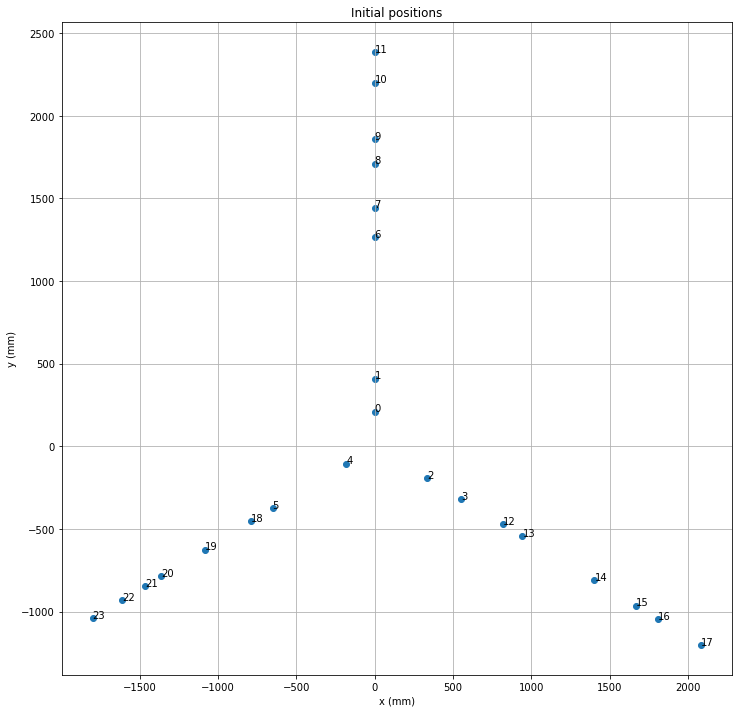

In [7]:
def i_y(i):
    return 2*i+1

def i_x(i):
    return 2*i


initial_guess = np.zeros(2*n_ant)

for i in range(n_ant):
    x,y = current_pos[i][0:2]*1000
    initial_guess[i_x(i)] = x
    initial_guess[i_y(i)] = y
    
    print(x,y)
initial_guess

pos_i = current_pos*1000
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1])
for i in range(0,pos_i.shape[0]):
    ax.text(pos_i[i,0], pos_i[i,1],f"{i}")

ax.grid(True)
ax.set_title('Initial positions')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('initial_positions.png')
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [8]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)


def p(x, i):
    return [x[i_x(i)],x[i_y(i)]]

max_err = 1200
def bounds():
    ret = [(0,0)]*48
    for i in range(24):
        _x,_y = pos_i[i,0], pos_i[i,1]
        ret[i_x(i)] = (_x - max_err, _x + max_err)
        ret[i_y(i)] = (_y - max_err, _y + max_err)
    # x-component of the north arm set to zero.
    for i in [0,1,6,7,8,9,10,11]:
        xval = pos_i[i,0]
        ret[i_x(i)] = ( - 2, + 2)
    
    return ret

bnd = bounds()

center = [0,0]

def radius_model(x):
    ret = []
    
    for i in range(n_ant):
        p_i = p(x,i)
        ret.append(dist(center, p_i))
        
    return np.array(ret)

non_nan_ij = []
non_nan_indices = []
for i in range(n_ant):
    for j in range(n_ant):
        if not np.isnan(m_ij[i,j]):
            non_nan_ij.append(m_ij[i,j])
            non_nan_indices.append([i,j])
non_nan_ij = np.array(non_nan_ij)
non_nan_indices = np.array(non_nan_indices)

def m_ij_model(x):
    ret = []
    for i in range(n_ant):
        p_i = p(x,i)

        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret.append(dist(p_j, p_i))
                
    return np.array(ret)
    
def radius_residual(x):
    predict = radius_model(x)
    return predict - radius

def m_ij_residual(x):
    predict = m_ij_model(x)
    return predict - non_nan_ij


def f(x):
    ret = 0
    for i in range(n_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

def f(x):
    # This is the final criterion for optimality. The sum of squared residuals.
    ret = np.sum(radius_residual(x)**2)
    ret += np.sum(m_ij_residual(x)**2)
    return ret

print(f(initial_guess))

662006.2323637417


We can see that the initial value of this optimality condition is about 600,000.

In [9]:
res = minimize(f, initial_guess, bounds=bnd)
res

      fun: 18555.484476675192
 hess_inv: <48x48 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.13426428e+01,  2.54658314e-03,  3.24180293e+00,  3.27417833e-03,
       -3.63797592e-04, -1.45519037e-03,  2.18278555e-03,  1.09139278e-03,
       -3.63797592e-04,  4.36557731e-03, -5.09316629e-03, -5.09316629e-03,
        1.45519153e-02, -1.09140518e-03, -4.72937248e-03, -7.27603456e-04,
        1.01863407e-02, -2.54661210e-03,  7.27595758e-04,  3.63801728e-04,
        4.36557457e-03, -8.36743975e-03, -3.31710910e+00,  3.63801728e-03,
       -3.63797592e-03, -7.27595184e-04,  5.09316629e-03, -1.81898796e-03,
       -1.09140518e-03, -1.81898796e-03, -2.54661210e-03, -8.36734462e-03,
        1.45520691e-03,  6.18455907e-03, -7.63983629e-03, -9.45884493e-03,
        0.00000000e+00,  3.63797592e-04,  1.45520691e-03,  2.18278555e-03,
        7.27603456e-04, -2.54658314e-03, -2.91041382e-03,  1.81898796e-03,
        7.27603456e-04, -1.01863326e-02, -4.00181901e-03,  6.54843111e-03])


In [10]:
err = res.jac.reshape((24,2))
rms = err # np.sqrt(np.sum(err**2, axis=1))
for i in range(24):
    print(f"Ant {i}:\tJac: {rms[i,0]:06.2f}, \t{rms[i,1]:06.2f}")

Ant 0:	Jac: 031.34, 	000.00
Ant 1:	Jac: 003.24, 	000.00
Ant 2:	Jac: -00.00, 	-00.00
Ant 3:	Jac: 000.00, 	000.00
Ant 4:	Jac: -00.00, 	000.00
Ant 5:	Jac: -00.01, 	-00.01
Ant 6:	Jac: 000.01, 	-00.00
Ant 7:	Jac: -00.00, 	-00.00
Ant 8:	Jac: 000.01, 	-00.00
Ant 9:	Jac: 000.00, 	000.00
Ant 10:	Jac: 000.00, 	-00.01
Ant 11:	Jac: -03.32, 	000.00
Ant 12:	Jac: -00.00, 	-00.00
Ant 13:	Jac: 000.01, 	-00.00
Ant 14:	Jac: -00.00, 	-00.00
Ant 15:	Jac: -00.00, 	-00.01
Ant 16:	Jac: 000.00, 	000.01
Ant 17:	Jac: -00.01, 	-00.01
Ant 18:	Jac: 000.00, 	000.00
Ant 19:	Jac: 000.00, 	000.00
Ant 20:	Jac: 000.00, 	-00.00
Ant 21:	Jac: -00.00, 	000.00
Ant 22:	Jac: 000.00, 	-00.01
Ant 23:	Jac: -00.00, 	000.01


The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [11]:
pos = res.x.reshape((24,2))
pos

array([[-2.00000000e+00,  2.07931748e+02],
       [-2.00000000e+00,  4.06403029e+02],
       [ 3.45776649e+02, -1.64594379e+02],
       [ 5.79393553e+02, -2.72438636e+02],
       [-1.75629176e+02, -1.12436427e+02],
       [-6.27158479e+02, -3.99822685e+02],
       [-1.49862541e+00,  1.26055081e+03],
       [ 1.35879335e+00,  1.43325171e+03],
       [ 1.67338546e+00,  1.69723404e+03],
       [ 5.34856329e-01,  1.86233906e+03],
       [ 2.19682211e-01,  2.19173586e+03],
       [ 2.00000000e+00,  2.38774332e+03],
       [ 8.50544014e+02, -3.98618229e+02],
       [ 9.73091742e+02, -4.68925948e+02],
       [ 1.46282967e+03, -6.83921297e+02],
       [ 1.73978604e+03, -8.16475497e+02],
       [ 1.88796177e+03, -8.86273483e+02],
       [ 2.17693451e+03, -1.02533613e+03],
       [-7.62698663e+02, -4.86369341e+02],
       [-1.05686361e+03, -6.68820930e+02],
       [-1.33158606e+03, -8.39309842e+02],
       [-1.43828022e+03, -9.03764619e+02],
       [-1.54836211e+03, -1.00336532e+03],
       [-1.

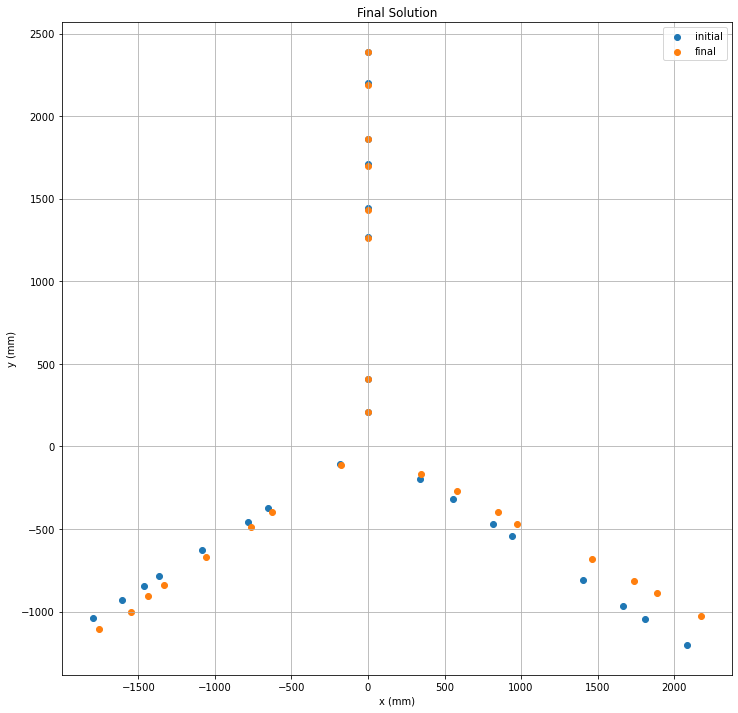

In [12]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1], label='initial')
ax.scatter(pos[:,0], pos[:,1], label='final')

ax.grid(True)
ax.set_title('Final Solution')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.legend()
plt.savefig('final_positions.png')
plt.show()

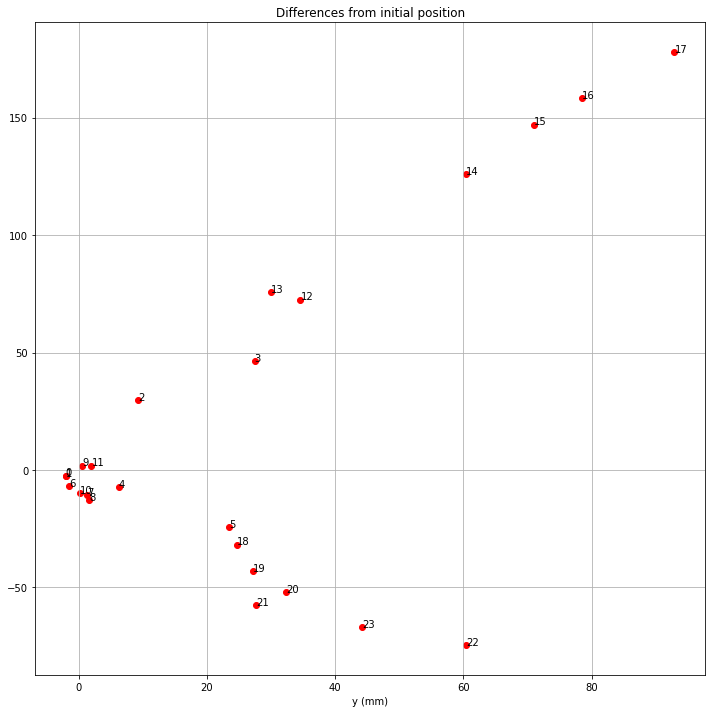

In [13]:
# Differences plot
diff = pos - pos_i[:,0:2]


fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(diff[:,0], diff[:,1], color='red')

for i in range(0,diff.shape[0]):
    ax.text(diff[i,0], diff[i,1],f"{i}")

ax.grid(True)
ax.set_title("Differences from initial position")
ax.set_xlabel('x (mm)')
ax.set_xlabel('y (mm)')
plt.savefig('differences.png')
plt.show()

In [14]:
# Residual plot
rres = radius_residual(res.x)
rres

A 0     -2.058633
A 1     -3.592050
A 2     -1.047261
A 3      2.249717
A 4     -3.463294
A 5     -9.235294
A 6     -0.448300
A 7     -2.747641
A 8     -9.765133
A 9     -1.660864
A 10    -7.264131
A 11     1.744161
A 12     2.319761
A 13    -3.815255
A 14    -6.187632
A 15    -2.155132
A 16    -5.363327
A 17    -1.683721
A 18    -9.420326
A 19    -3.287352
A 20    -0.972542
A 21     2.658438
A 22   -10.961463
A 23    -0.707905
Name: 0, dtype: float64

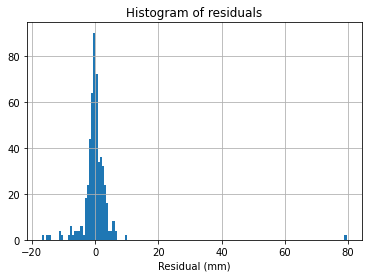

In [15]:
# ij resdual
ijres = m_ij_residual(res.x)
plt.hist(ijres, bins='fd');
plt.title("Histogram of residuals")
plt.xlabel("Residual (mm)")
plt.grid(True)
plt.savefig("residual_histogram.png")

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [16]:
absres = np.abs(ijres)
p95 = np.percentile(absres, 95)

print(f"95th percentile of residuals is {p95:4.2f} mm")
ijres_matrix = np.zeros_like(m_ij)
for r, i, j in zip(ijres, non_nan_indices[:,0], non_nan_indices[:,1]):
    if np.abs(r) > p95:
        print(f" res[{i},{j}] = {r:3.1f}")
    ijres_matrix[i,j] = r
    


95th percentile of residuals is 6.60 mm
 res[2,22] = -10.5
 res[3,22] = -11.2
 res[4,22] = -7.5
 res[5,22] = -7.7
 res[8,13] = 10.0
 res[12,22] = -11.0
 res[13,8] = 10.0
 res[13,18] = -7.1
 res[13,19] = -8.2
 res[13,20] = -7.7
 res[13,21] = -16.7
 res[13,22] = 79.5
 res[14,22] = -14.9
 res[15,22] = -14.5
 res[18,13] = -7.1
 res[19,13] = -8.2
 res[20,13] = -7.7
 res[21,13] = -16.7
 res[22,2] = -10.5
 res[22,3] = -11.2
 res[22,4] = -7.5
 res[22,5] = -7.7
 res[22,12] = -11.0
 res[22,13] = 79.5
 res[22,14] = -14.9
 res[22,15] = -14.5


## Output best estimates

Write some json files...

In [17]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[-2.000e-03,  2.080e-01,  0.000e+00],
       [-2.000e-03,  4.060e-01,  0.000e+00],
       [ 3.460e-01, -1.650e-01,  0.000e+00],
       [ 5.790e-01, -2.720e-01,  0.000e+00],
       [-1.760e-01, -1.120e-01,  0.000e+00],
       [-6.270e-01, -4.000e-01,  0.000e+00],
       [-1.000e-03,  1.261e+00,  0.000e+00],
       [ 1.000e-03,  1.433e+00,  0.000e+00],
       [ 2.000e-03,  1.697e+00,  0.000e+00],
       [ 1.000e-03,  1.862e+00,  0.000e+00],
       [ 0.000e+00,  2.192e+00,  0.000e+00],
       [ 2.000e-03,  2.388e+00,  0.000e+00],
       [ 8.510e-01, -3.990e-01,  0.000e+00],
       [ 9.730e-01, -4.690e-01,  0.000e+00],
       [ 1.463e+00, -6.840e-01,  0.000e+00],
       [ 1.740e+00, -8.160e-01,  0.000e+00],
       [ 1.888e+00, -8.860e-01,  0.000e+00],
       [ 2.177e+00, -1.025e+00,  0.000e+00],
       [-7.630e-01, -4.860e-01,  0.000e+00],
       [-1.057e+00, -6.690e-01,  0.000e+00],
       [-1.332e+00, -8.390e-01,  0.000e+00],
       [-1.438e+00, -9.040e-01,  0.000e+00],
       [-1

In [18]:
json_result = {}
json_result["antenna_positions"] = result.tolist()
print(json.dumps(json_result, indent=4, separators=(',', ': ')))

{
    "antenna_positions": [
        [
            -0.002,
            0.208,
            0.0
        ],
        [
            -0.002,
            0.406,
            0.0
        ],
        [
            0.346,
            -0.165,
            0.0
        ],
        [
            0.579,
            -0.272,
            0.0
        ],
        [
            -0.176,
            -0.112,
            0.0
        ],
        [
            -0.627,
            -0.4,
            0.0
        ],
        [
            -0.001,
            1.261,
            0.0
        ],
        [
            0.001,
            1.433,
            0.0
        ],
        [
            0.002,
            1.697,
            0.0
        ],
        [
            0.001,
            1.862,
            0.0
        ],
        [
            0.0,
            2.192,
            0.0
        ],
        [
            0.002,
            2.388,
            0.0
        ],
        [
            0.851,
            -0.399,
            0.0
 

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


    tart_upload_antenna_positions --api https://tart.elec.ac.nz/rhodes --pw=xxxx --file rhodes_antenna_positions.json
